In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [58]:

# Gaussian membership function
def gaussian(x, c, sigma):
    return np.exp(-(((x - c) / (sigma)) ** 2))


In [59]:
def simulation(N):
        u = np.sin(np.linspace(0, 2 * np.pi, N))  # Input signal u(k)
        y_true = np.zeros(N)
        output = np.zeros(N)
        y_k = 0  # Initial value of y(k)
        y_k_1 = 0  # Initial value of y(k-1)
        # Compute the true output y(k+1) based on the system dynamics


        for k in range(2, N):
            y_true[k] = (
                0.3 * y_k
                + 0.6 * y_k_1
                + 0.6 * np.sin(np.pi * u[k])
                + 0.3 * np.sin(3 * np.pi * u[k])
                + 0.1 * np.sin(5 * np.pi * u[k])
            )
            # Update the previous values
            output[k]=y_true[k] - 0.3 * y_k - 0.6 * y_k_1
            y_k_1 = y_k
            y_k = y_true[k]
            
        return u,output


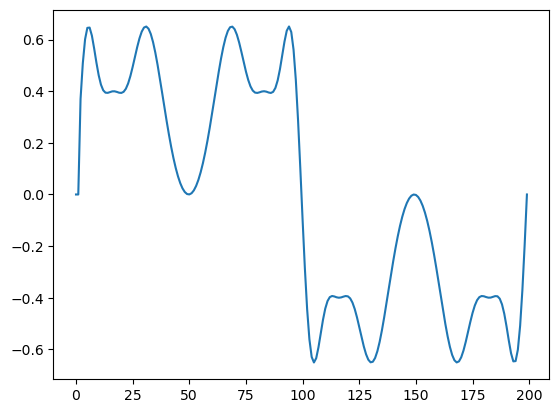

In [60]:
N=200
u,y_true = simulation(N)

plt.plot(y_true)
plt.show()

In [61]:
# Fuzzy system output based on Gaussian membership functions
def fuzzy_system(x, centers, sigmas, y):
    # Compute the z_i values for each input using Gaussian membership functions
    z = np.array([gaussian(x, c, sigma) for c, sigma in zip(centers, sigmas)])

    # Compute b as the sum of the z_i's
    b = np.sum(z)

    # Compute a as the weighted sum of centers (using z_i as weights)
    a = np.sum(z * y)

    # Compute the output of the fuzzy system as f(x) = a / b
    if b != 0:
        f_x = a / b
    else:
        f_x = 0  # In case the sum of z_i's is zero (just for safety)

    return f_x, z, b, a


# Gradient Descent for the centers and spreads
def gradient_descent_update(x, y_true, centers, sigmas, y, alpha, M, z, b, a):
    # Predicted output from fuzzy system
    y_pred = a / b

    # Compute the error (y_true is the actual output)
    error = y_true - y_pred

    # Update the centers (c_i) and spreads (sigma_i) using gradient descent
    for i in range(M):
        # Gradient with respect to the center c_i
        grad_y = (-error / b) * z[i]
        grad_c = (
            ((-error * z[i]) / b)
            * (y[i] - y_pred)
            * z[i]
            * (2 * (x - centers[i]) / sigmas[i] ** 2)
        )
        # Gradient with respect to the spread sigma_i
        grad_sigma = (
            ((-error * z[i]) / b)
            * (y[i] - y_pred)
            * z[i]
            * (2 * (x - centers[i]) ** 2 / sigmas[i] ** 3)
        )

        # Update the parameters using the gradients
        y[i] -= alpha * grad_y
        centers[i] -= alpha * grad_c
        sigmas[i] -= alpha * grad_sigma

    return centers, sigmas, y

        

# Simulate the system for training
def predict(u ,y_true, alpha, M):

    N= len(u)
    # Time series for the true and predicted values
    y_pred = np.zeros(N)

    # Initialize Gaussian membership function parameters (centers and spreads)
    centers = np.linspace(-1, 1, M)  # Initial centers for Gaussian functions
    sigmas = np.ones(M) * 0.5  # Initial spreads for the Gaussian functions
    y = np.ones(M) * 0.5

    # Training loop
    for k in range(2, N):

        # Compute fuzzy system output and intermediate values
        f_x, z, b, a = fuzzy_system(u[k], centers, sigmas,y)


        # Update centers and sigmas using gradient descent
        centers, sigmas,y = gradient_descent_update(
            u[k], y_true[k], centers, sigmas,y, alpha, M, z, b, a
        )

        # Predict the output from the fuzzy system
        # y_pred[k] = (
        #     0.3 * y_k
        #     + 0.6 * y_k_1
        #     + f_x
        # )
        y_pred[k] = f_x


    return y_pred, centers, sigmas, y 


def test_system(x_test, y_test, centers, sigmas, y):
    N = len(x_test)
    y_pred = np.zeros(N)
    for k in range(2, N):
        # Compute fuzzy system output and intermediate values
        f_x, z, b, a = fuzzy_system(x_test[k], centers, sigmas,y)
        y_pred[k] = f_x
    
    print("RMSE: ",r2_score(y_pred,y_test))
    
    return y_pred , r2_score(y_pred,y_test)


In [69]:
# Run the simulation
alpha = 0.9  # Learning rate
M = 8 # Number of fuzzy rules (membership functions)
y_pred, centers, sigmas, y  = predict(u,y_true, alpha, M)

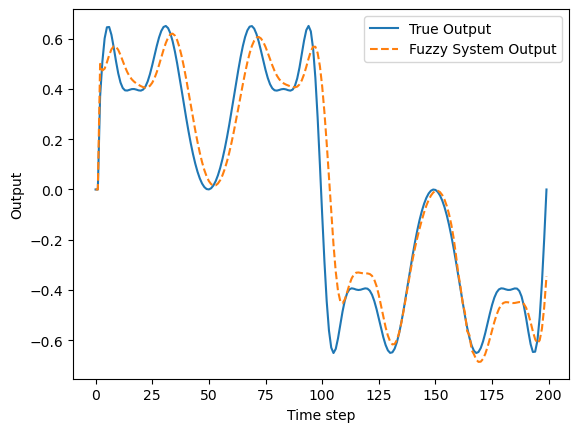

In [70]:
# Plot the results
plt.plot(y_true, label="True Output")
plt.plot(y_pred, label="Fuzzy System Output", linestyle="dashed")
plt.xlabel("Time step")
plt.ylabel("Output")
plt.legend()
plt.show()

In [71]:
r2_score(y_true,y_pred)

0.9131527944069733